In [20]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
sample_size = 0.01
use_sample = True
best_model_path = "best_models/autoencoder_1.pth"
epochs = 10

# Model parameters
hidden_dims = [64, 32, 16]
latent_dim = 8

# Training parameters
lr = 0.001  # 0.1, 0.01, 0.0001
batch_size = 128  # 32, 64, 256

In [21]:
import pandas as pd

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_full.csv"
)
train_df = pd.read_csv(train_set_path)

if use_sample:
    train_df = train_df.sample(frac=sample_size, random_state=42).reset_index(drop=True)

print(train_df.shape)

(673, 122)


Splitting Data

In [22]:
from sklearn.decomposition import PCA

In [23]:
from sklearn.model_selection import train_test_split

X_train_full = train_df.values

X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=42)
X_train = X_train.values
X_val = X_val.values

pca_autoencoder = PCA(n_components=68)
X_train = pca_autoencoder.fit_transform(X_train)
X_val = pca_autoencoder.transform(X_val)

print(X_train.shape, X_val.shape, X_train_full.shape)

(538, 68) (135, 68) (673, 122)


In [24]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [25]:
input_dim = X_train.shape[1]

training autoencoder

In [26]:
from models import BatchNormAutoencoder
from torch import nn, optim

autoencoder = BatchNormAutoencoder(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    activation_type="LeakyReLU",
    output_activation_type="Sigmoid",
)

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
criterion = nn.MSELoss()


Using device: cpu
Training autoencoder...
Epoch 1/10, Train Loss: 0.2791937351, Val Loss: 0.2880578935
✅ Model saved with val_loss: 0.2880578935
Epoch 2/10, Train Loss: 0.2485338748, Val Loss: 0.2780174613
✅ Model saved with val_loss: 0.2780174613
Epoch 3/10, Train Loss: 0.2181424320, Val Loss: 0.2623442560
✅ Model saved with val_loss: 0.2623442560
Epoch 4/10, Train Loss: 0.1887105912, Val Loss: 0.2404669300
✅ Model saved with val_loss: 0.2404669300
Epoch 5/10, Train Loss: 0.1609673142, Val Loss: 0.2147372141
✅ Model saved with val_loss: 0.2147372141
Epoch 6/10, Train Loss: 0.1394839257, Val Loss: 0.1862612739
✅ Model saved with val_loss: 0.1862612739
Epoch 7/10, Train Loss: 0.1199838921, Val Loss: 0.1567338035
✅ Model saved with val_loss: 0.1567338035
Epoch 8/10, Train Loss: 0.1023198992, Val Loss: 0.1318681501
✅ Model saved with val_loss: 0.1318681501
Epoch 9/10, Train Loss: 0.0895381749, Val Loss: 0.1110288948
✅ Model saved with val_loss: 0.1110288948
Epoch 10/10, Train Loss: 0.078

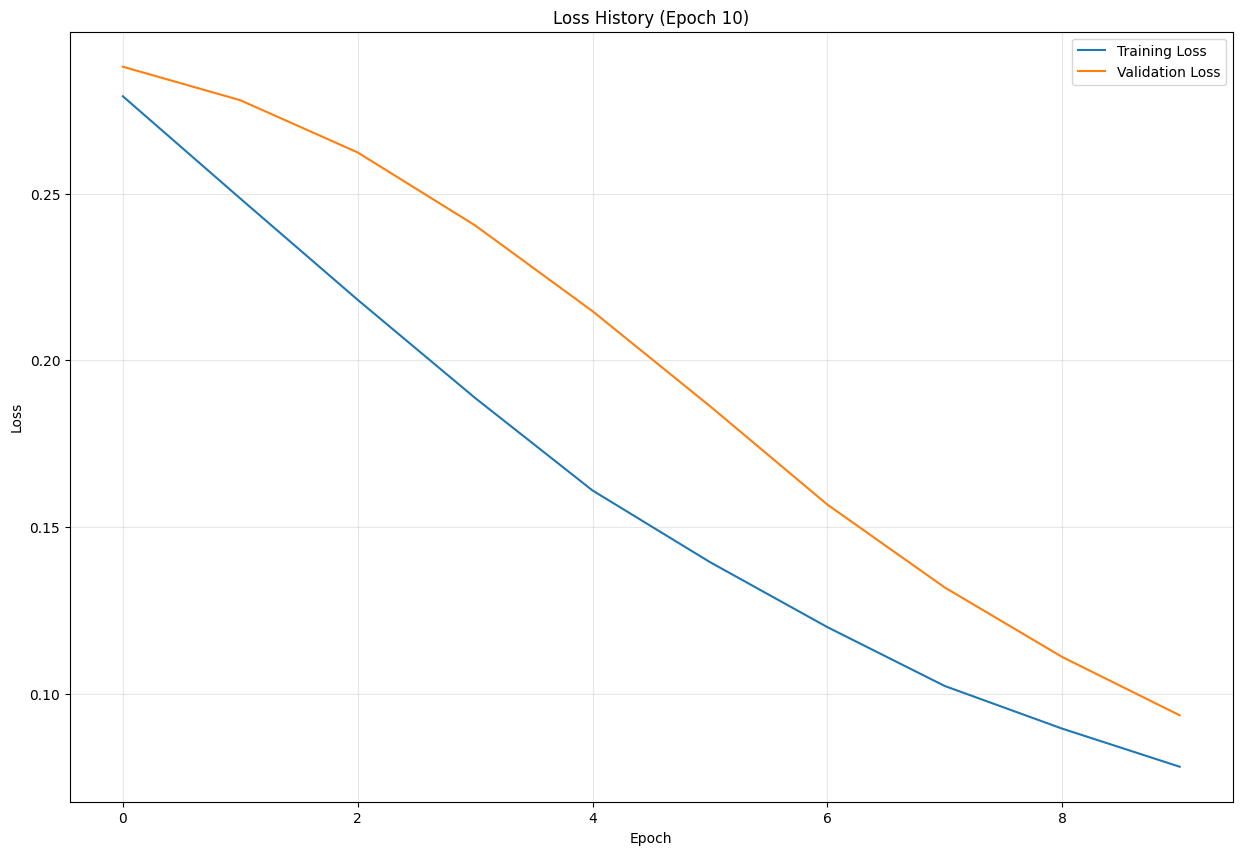

In [27]:
from tuning_utils import train_autoencoderV2


history, is_good_model = train_autoencoderV2(
    model=autoencoder,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    val_loader=val_loader,
    epochs=epochs,
    best_model_path=best_model_path,
    verbose=True,
)

In [28]:
# Load best model
checkpoint = torch.load(best_model_path)
autoencoder.load_state_dict(checkpoint["model_state_dict"])
autoencoder.eval()

BatchNormAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, 

Training OCSVM

In [29]:
from torch.utils.data import ConcatDataset
import numpy as np

pca_ocsvm = PCA(n_components=68)
X_train_full = pca_ocsvm.fit_transform(X_train_full)

X_train_full_tensor = torch.FloatTensor(X_train_full)
X_train_full_dataset = TensorDataset(X_train_full_tensor)
X_train_full_loader = DataLoader(X_train_full_dataset, batch_size=128, shuffle=False)


X_train_encoded = []
with torch.no_grad():
    for data in X_train_full_loader:
        data_x = data[0].to(device)
        encoded = autoencoder.encode(data_x)
        X_train_encoded.append(encoded.cpu().numpy())

X_train_encoded = np.vstack(X_train_encoded)

In [30]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.2)

ocsvm.fit(X_train_encoded)

OneClassSVM(gamma='auto', nu=0.2)

Prediction

In [31]:
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)
test_df = pd.read_csv(test_set_path)
print(test_df.shape)

(22543, 125)


In [32]:
# Splitting into X and y
X_test = test_df.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_class"]

In [33]:
# Extract encoded features in test set
X_test = pca_ocsvm.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test).to(device)

test_dataset = TensorDataset(X_test_tensor)
X_test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

X_test_encoded = []
with torch.no_grad():
    for data in X_test_loader:
        data_x = data[0].to(device)
        encoded = autoencoder.encode(data_x)
        X_test_encoded.append(encoded.cpu().numpy())

X_test_encoded = np.vstack(X_test_encoded)

In [34]:
y_pred = ocsvm.predict(X_test_encoded)

Evaluation

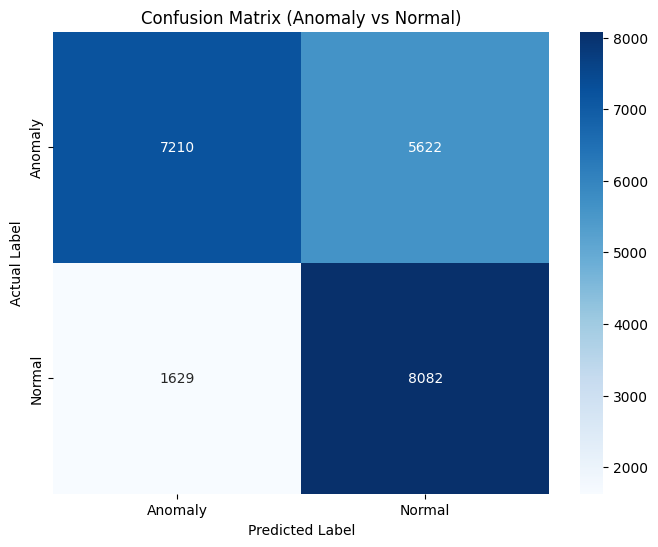

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [36]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.82      0.56      0.67     12832
      Normal       0.59      0.83      0.69      9711

    accuracy                           0.68     22543
   macro avg       0.70      0.70      0.68     22543
weighted avg       0.72      0.68      0.68     22543

Precision: 0.8157031338386695
Recall: 0.5618765586034913
F1 Score: 0.6654053804623691
Accuracy: 0.6783480459566162


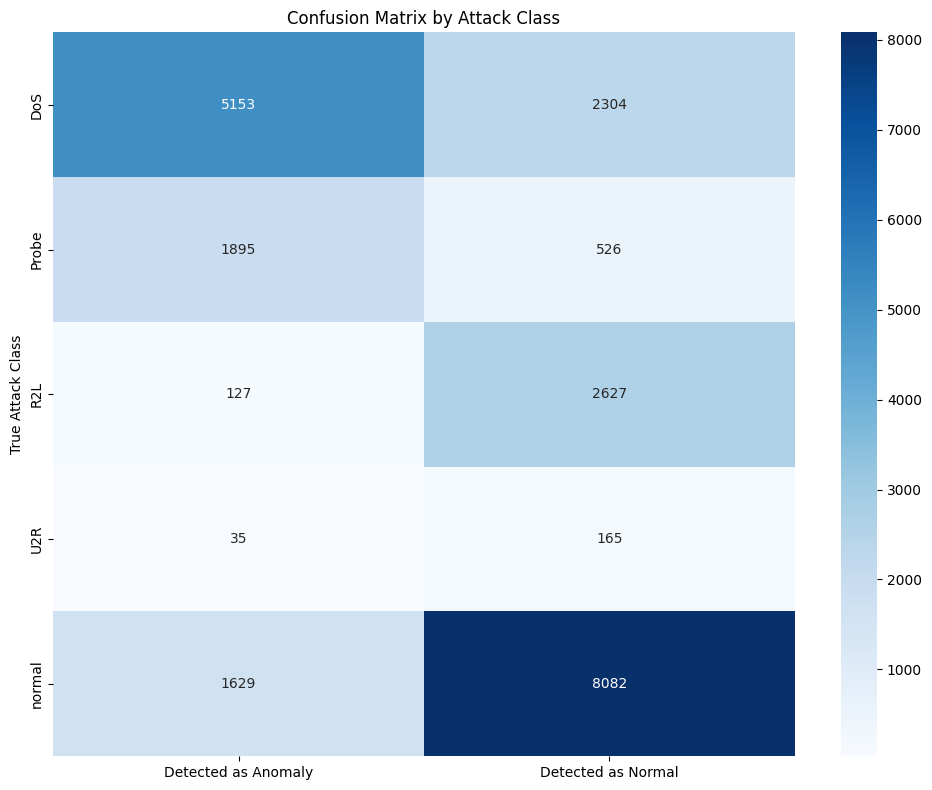

In [37]:
def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [38]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
DoS: 0.6910 (5153/7457)
Probe: 0.7827 (1895/2421)
R2L: 0.0461 (127/2754)
U2R: 0.1750 (35/200)
normal: 0.1677 (1629/9711)
